# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

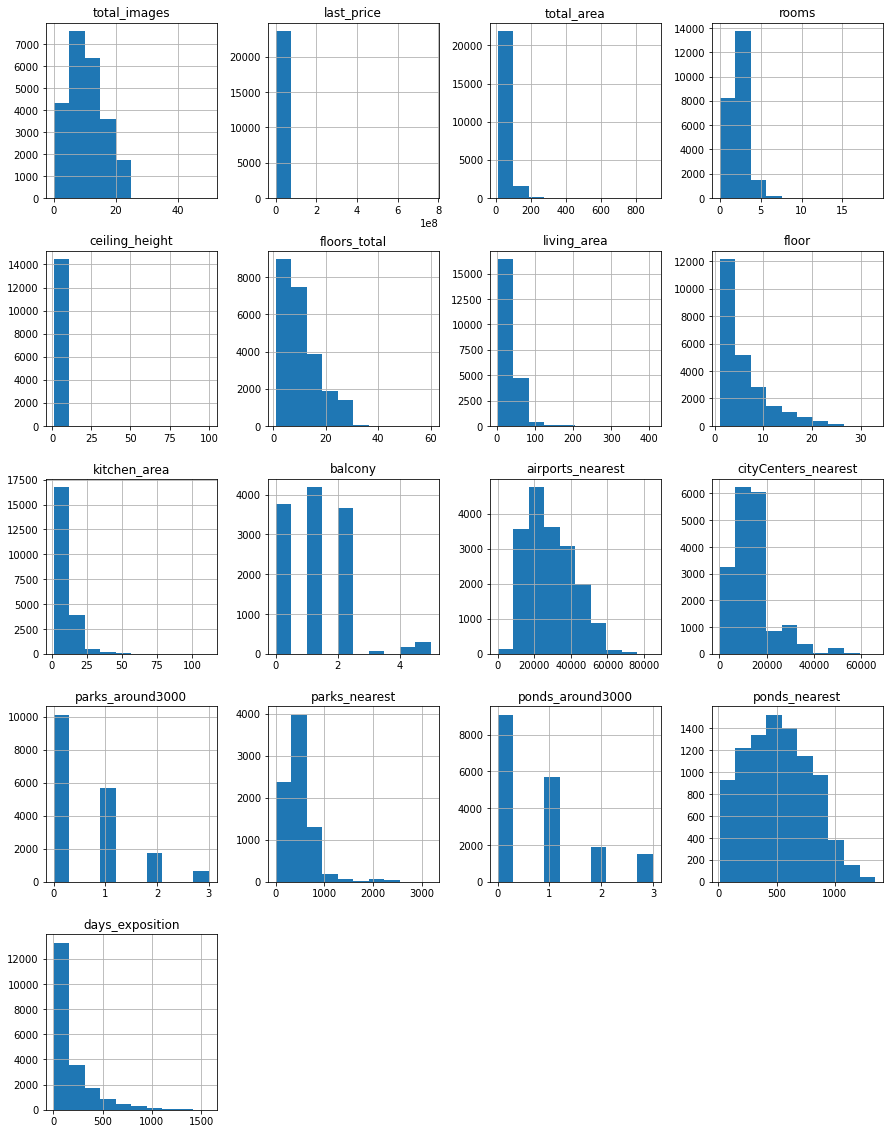

In [40]:
data.info()
data.hist(figsize=(15, 20))

#### Вывод  

■ Имеются пропуски в floors_total, living_area, kitchen_area, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest.   
• Некоторые пропуски, например, высота потолков, размер кухни, жилой площади, возможно означают стандартизацию размеров. Данные можно заполнить средними значениями или медианой. Так же есть необязательные поля для заполнения анкеты, которые могли пропустить.   
■ У значений first_day_exposition, floors_total, is_apartment, parks_around3000, ponds_around3000, days_exposition неверный тип данных. 

### Предобработка данных

In [41]:
data['cityCenters_nearest'].value_counts()
data['airports_nearest'].value_counts()
data['rooms'].value_counts()
data['floor'].value_counts()
data['ceiling_height'].value_counts()
data['is_apartment'].value_counts()
data['parks_around3000'].value_counts()
data['parks_nearest'].value_counts()
data['ponds_around3000'].value_counts()
data['total_images'].value_counts()
data['total_area'].value_counts()

#Почему в floors_total есть пропуски - не ясно
data[data['floors_total'].isna()]

#Найдем общее число пропусков
print(data.isna().sum())

#Если заменить пропуски на False, они будут считаться как появившиеся недавно. 
##Здесь напутал столбец, заполняя значения другого. 
#data['is_apartment'] = data['is_apartment'].fillna(False)

#Т.к. пропусков слишком много, а апартаменты это, вкратце, нежилые помещения, в которых создали условия для проживания, 
#На данном этапе, я уже понимаю, что значения этого столбца мне не пригодятся для исследования, поэтому пока оставлю так.



total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


■ В первый раз пропустил подсчет общего числа пропусков, и не заметил что потерял столько данных.    
• Пропуски в 'is_apartment' принял решение оставить без изменений.    
• Количество пропусков в количестве парков и прудов значительно меньше, чем пропусков в расстоянии до ближайшего парка или пруда. Можно предположить, что авторы объявлений могут и преукрашивать, и путаться.    
• Пропуски в значениях 'ceiling_height' скорее всего обусловлены простым незнанием точной высоты потолка, я тоже не знаю, руками не достаю и ладно. Дальше можно будет высчитать медиану и заполнить отсутствующие значения.  
• Пропуски в 'living_area' в дальнейшем не исказят выводы, поэтому можно их оставить. Причина появления, возможно, как у высоты потолков.   
• С 'kitchen_area', кажется, все просто. Значения могут отсутсвовать по причине отсутствия кухни, проверить, является ли помещение студией возможности не вижу.   
• Пропуски в 'locality_name' можно убрать со стороны разработчиков сайта. Сделать поле обязательным для заполнения. Кол-во пропусков слишком мало, чтобы повлиять на расчеты.   
• Так же и в 'days_exposition', значение легко высчитать, т.к. дата публикации есть.  
 

In [42]:
#получение суммарного количества дубликатов
data.duplicated().sum()
#удаление всех дубликатов 
data=data.drop_duplicates().reset_index(drop=True)
#проверка на отсутствие
data.duplicated().sum()

0

In [73]:
#Найдем и заменим неявные дубликаты.
data['locality_name'].unique()
data['locality_name'] = data['locality_name'].replace('поселок городского типа Рябово', 'поселок Рябово')
data['locality_name'] = data['locality_name'].replace('поселок Тельмана', 'посёлок Тельмана')

In [75]:
#Приведем данные к нужному типу
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%d')

#Заполним отсутствующие значения медианным
data['days_exposition']=data['days_exposition'].fillna(data['days_exposition'].median())

#Предположим, что пропуски в колонке балконов, это не невнимательность, а отсутвие балконов. 
#"У моей бабушки и балкон, и лоджия. Указать 1 балкон или 2 балкона? А если бы была только лоджия?"
data['balcony'] = data['balcony'].fillna(0).astype('int')

#Пропуски в 'floors_total'. Возможно, это одноэтажные постройки в области, владельцы которых, не посчитали нужным указать единицу.
data['floors_total'] = data['floors_total'].fillna(1)

#Абсолютная точность значений не требуется, упростим себе жизнь и сохраним глаза
data['last_price'] = data['last_price'].astype('int')

#Приведем значения хотя бы к правильному типу, не оставлять же
data['is_apartment'] = data['is_apartment'].astype('bool')
data['first_day_exposition'].unique()

array(['2019-03-07T00:00:00.000000000', '2018-12-04T00:00:00.000000000',
       '2015-08-20T00:00:00.000000000', ...,
       '2014-12-29T00:00:00.000000000', '2016-09-12T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000'], dtype='datetime64[ns]')

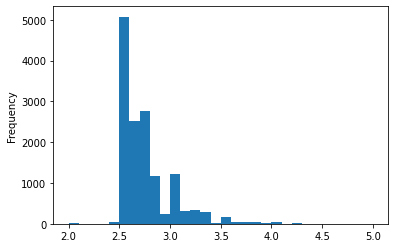

In [45]:
#Разберемся с высотой потолка
data['ceiling_height'].describe()
#Нужна зависимость от других параметров
data.corr()
#Посмотроим гистрограмму, исключив все невероятные значения
data['ceiling_height'].sort_values().plot(y='ceiling_height', kind='hist', bins=30, range=(2,5))
data['ceiling_height'].value_counts()
data[data['ceiling_height'] > 5].sort_values('ceiling_height').tail(10)
#Заполним пропущенные значения
data['ceiling_height'].isna().sum()
#Среднее и медиана почти не отличаются, можно заполнить пропуски медианой.
median_height = data['ceiling_height'].median()
data['ceiling_height'].fillna(median_height, inplace=True)

### Посчитайте и добавьте в таблицу новые столбцы

In [46]:
#Цена квардратного метра
data['price_per_square'] = data['last_price'] / data['total_area']
#print(data['price_per_square'])
data['price_per_square'] = data['price_per_square'].astype('int')

#Добавляю в таблицу: день, месяц и год публикации объявления
data['exp_year'] = data['first_day_exposition'].dt.year
data['exp_day'] = data['first_day_exposition'].dt.weekday
data['exp_month'] = data['first_day_exposition'].dt.month

#тип этажа квартиры (значения — «первый», «последний», «другой»)
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
    
data['floor_category'] = data.apply(floor_category, axis=1)

#Отношение жилой площади к общей
data['living_area_att'] = data['living_area'] / data['total_area']

#Отношение площади кухни к общей
data['kitchen_area_att'] = data['kitchen_area'] / data['total_area']

#расстояние в км до центра города
print(data['cityCenters_nearest'])
data['km_to_center'] = (round(data['cityCenters_nearest'] / 1000))
#data['km_to_center'] = data['km_to_center'].astype('int')
print(data['km_to_center'])



0        16028.0
1        18603.0
2        13933.0
3         6800.0
4         8098.0
          ...   
23694     4232.0
23695        NaN
23696        NaN
23697    10364.0
23698        NaN
Name: cityCenters_nearest, Length: 23699, dtype: float64
0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: km_to_center, Length: 23699, dtype: float64


### Проведите исследовательский анализ данных

#### Задание 1

Изучите следующие параметры объектов: общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.

<AxesSubplot:>

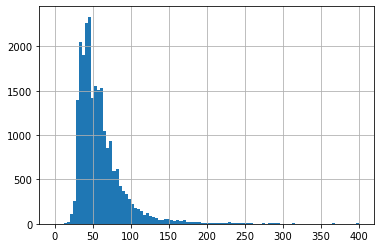

In [47]:
data['total_area'].hist(bins=100, range=(0,400))

Больше всего продаж квартир с площадью от 40 до 49 квадратных метров.

<AxesSubplot:>

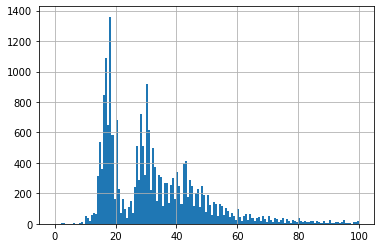

In [48]:
data['living_area'].hist(bins=150, range=(0,100))

Больше всего квартир с площадью от 15 до 18 кв.м., следующий, менее выразительный пик в кол-ве квартир с площадью от 25 до 30 кв.м.

<AxesSubplot:>

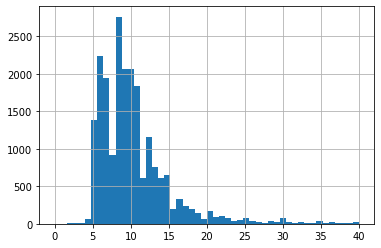

In [49]:
data['kitchen_area'].hist(bins=50, range=(0,40))

В основном, площадь кухонь лежит в диапазоне от 5 до 15 кв.м. с пиком в 7-8 кв.м. 

<AxesSubplot:>

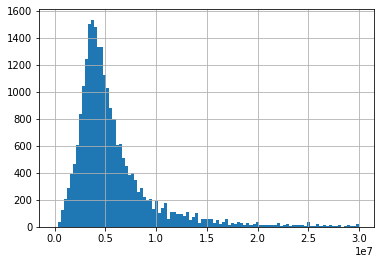

In [50]:
data['last_price'].hist(bins=100, range=(0,30000000))

Больше всего квартир продается за 3-4 млн. руб.

<AxesSubplot:>

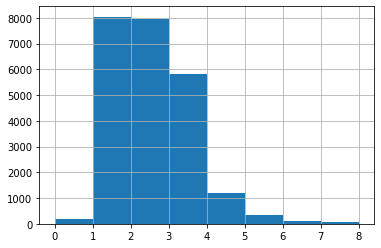

In [51]:
data['rooms'].hist(bins=8, range=(0,8))

Кол-во продаж 1-2 комнатных квартир практически равны. Дальше идет резкий спад в продаже 3х и 4х комнатных квартир.

<AxesSubplot:>

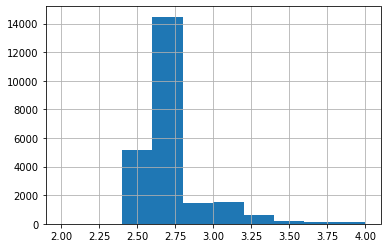

In [52]:
data['ceiling_height'].hist(bins=10, range=(2, 4))

Больше продаж квартир с высотой потолка в 2.6-2.75 метра.

<AxesSubplot:>

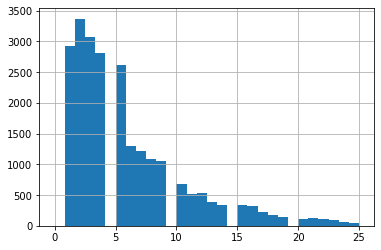

In [53]:
data['floor'].hist(bins=30, range=(0,25))

Больше квартир продается на низких этажах. Самое большое кол-во в диапазоне от 0 до 5 этажей. Чем выше этаж, тем меньше продаж.

<AxesSubplot:>

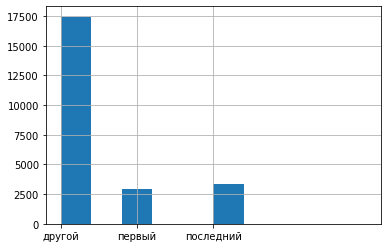

In [54]:
data['floor_category'].hist(bins=10, range=(0,4))

Первый и последний этаж менее предпочтительны к покупке. Больше всего продаж в категории "другой". Скорее всего, это обусловлено и тем, что в категорию "другой" попадает больше значений при сортировке.

<AxesSubplot:>

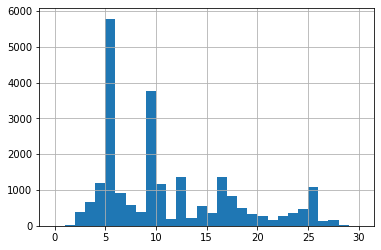

In [55]:
data['floors_total'].hist(bins=30, range=(0,30))

Пиковые значения гистрограммы соответствуют типу застройки Санкт-Петербурга. Больше всего 5-ти этажных домов, высоток намного меньше. 

<AxesSubplot:>

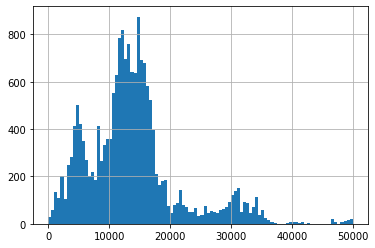

In [56]:
data['cityCenters_nearest'].hist(bins=100, range=(0,50000))

Большинство объявлений распределены на расстоянии от 11 до 16 км от центра города. 

<AxesSubplot:>

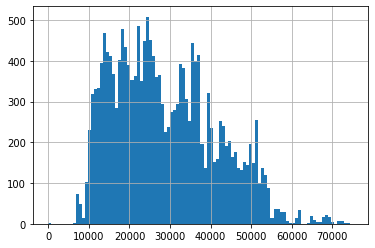

In [57]:
data['airports_nearest'].hist(bins=100, range=(0,75000))

Больше всего продаж квартир на расстоянии в 24км от ближайшего аэропорта. Распределение гистрограммы так же подтверждает особенности выбора места для аэропортов - стремление к равноудаленности от разных точек города.  

<AxesSubplot:>

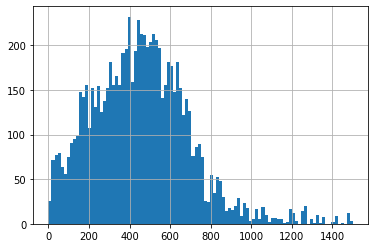

In [58]:
data['parks_nearest'].hist(bins=100, range=(0,1500))

Парки, относительно проданных квартир, так же, находятся в пешей доступности, больше всего значений в диапазоне от 390 до 570 метров.

<AxesSubplot:>

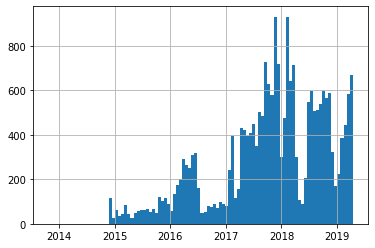

In [59]:
data['first_day_exposition'] = data['first_day_exposition'].dt.round('1D')
data['first_day_exposition'].hist(bins=100, range=(16000,18000))

Пиковые значения гистограммы - в конце 17го и в начале 18го года. Так же, виден заметный рост кол-ва продаж, начиная с 16го года. Чем обсуловены падения продаж в середине 16го и 18го годов сказать сложно.

#### Задание 2

Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.  
Постройте гистограмму.
Посчитайте среднее и медиану.
В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?

<AxesSubplot:>

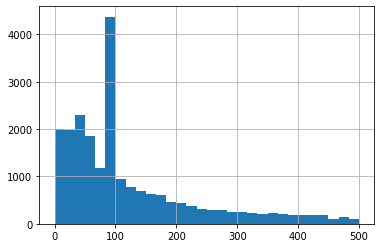

In [60]:
data['days_exposition'].hist(bins=30, range=(0,500))

Учитывая, что отсутствующие значения я заменил на медианные, не удивительно, что график смещен к значению 95 дней.

In [61]:
data['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

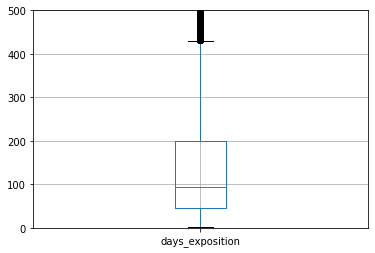

In [62]:
plt.ylim(0,500)
data.boxplot(column='days_exposition')
plt.show()

Медианой значений является 50% - 95 дней. Много значений лежит за 1.5IQR. Быстрыми продажами могут считаться те, которые произошли в первый же день. Необычайно долгими те, чьи  значения 'days_exposition' > Q3+1.5IQR.

#### Задание 3
Какие факторы больше всего влияют на общую (полную) стоимость объекта?
Изучите, зависит ли цена от:   
■ общей площади;   
■ жилой площади;   
■ площади кухни;   
■ количества комнат;   
■ этажа, на котором расположена квартира (первый, последний, другой);    
■ даты размещения (день недели, месяц, год).    
Постройте графики, которые покажут зависимость цены от указанных выше параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы.

Корреляция Пирсона равна: 0.3019601438779257


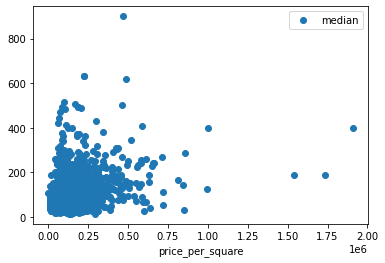

In [100]:
#Зависимость цены квартиры от общей площади
total_area_pivot = data.pivot_table(index='price_per_square', values='total_area', aggfunc=['count', 'mean', 'median'])
total_area_pivot.columns = ['count', 'mean', 'median']

total_area_pivot.plot(y='median', style='o')

pirs = data['total_area'].corr(data['price_per_square'])
print(f'Корреляция Пирсона равна: {pirs}')


Зависимость 'total_price' от 'price_per_square' слабо выражена ~0.3

Корреляция Пирсона равна: 0.2263463609099256


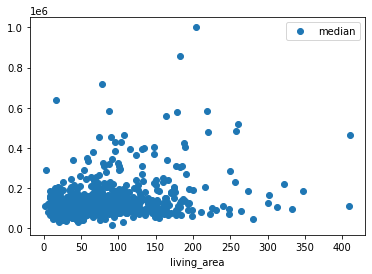

In [64]:
total_area_pivot = data.pivot_table(index='living_area', values='price_per_square', aggfunc=['count', 'mean', 'median'])
total_area_pivot.columns = ['count', 'mean', 'median']

total_area_pivot.plot(y='median', style='o')

pirs = data['living_area'].corr(data['price_per_square'])
print(f'Корреляция Пирсона равна: {pirs}')

Зависимость 'total_price' от 'living_area' слабо выражена ~0.2

Корреляция Пирсона равна: 0.3974934510795303


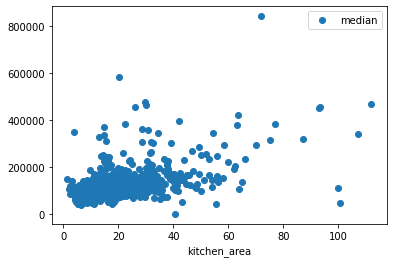

In [65]:
total_area_pivot = data.pivot_table(index='kitchen_area', values='price_per_square', aggfunc=['count', 'mean', 'median'])
total_area_pivot.columns = ['count', 'mean', 'median']

total_area_pivot.plot(y='median', style='o')

pirs = data['kitchen_area'].corr(data['price_per_square'])
print(f'Корреляция Пирсона равна: {pirs}')

Корреляция Пирсона 'total_price' от 'kitchen_area' выражена сильнее, чем от первых двух вариантов, и составляет примерно ~0.4

Корреляция Пирсона равна: 0.05541949967059211


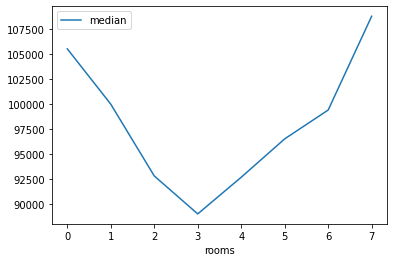

In [66]:
total_area_pivot = data.pivot_table(index='rooms', values='price_per_square', aggfunc=['count', 'mean', 'median'])
total_area_pivot.columns = ['count', 'mean', 'median']

total_area_pivot.query('count > 50').plot(y='median')

pirs = data['rooms'].corr(data['price_per_square'])
print(f'Корреляция Пирсона равна: {pirs}')

Стоимость квардратного метра сильнее всего падает, когда общее число комнат равно трем. Зависимость проявляется только в этом случае.

In [78]:
#total_area_pivot = data.query('floor_category != "другой"').pivot_table(index='floor_category', values='price_per_square', aggfunc=['count', 'mean', 'median'])
#total_area_pivot.columns = ['count', 'mean', 'median']

#total_area_pivot.plot.hexbin(x='floor_category', y='median', gridsize=30, figsize=(8,6))
#total_area_pivot.plot(y = 'median')

#pirs = data['floor'].corr(data['price_per_square'])
#print(f'Корреляция Пирсона равна: {pirs}')


#Тоже не нравился график, попробую снова через сводную таблицу. В первый раз не вышло. (все проще, чем я думал)
data.pivot_table(index='floor_category', values='price_per_square')


,price_per_square
floor_category,
другой,103486.293305
первый,81983.111759
последний,93410.267686


Самая низкая цена квадратного метра на первом этаже. Т.к. кол-во значений в "другой" превышает кол-во значений в двух других категориях, это самый дорогой и востребованный сегмент. Уверен, многие, как и я, любят сидеть высоко и смотреть далеко, поэтому категория "последний" занимает второе место по высоте цены за квадратный метр.

<AxesSubplot:xlabel='exp_day'>

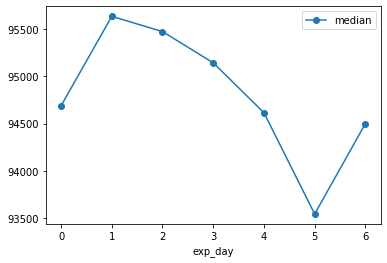

In [68]:
total_area_pivot = data.pivot_table(index='exp_day', values='price_per_square', aggfunc=['count', 'mean', 'median'])
total_area_pivot.columns = ['count', 'mean', 'median']

total_area_pivot.plot(y='median', style='o-')

#pirs = data['exp_day'].corr(data['price_per_square'])
#print(f'Корреляция Пирсона равна: {pirs}')

По непонятным причинам, медианное значение стоимости квартир ближе к субботе становится ниже, чем в остальные дни недели, а ко вторнику становятся выше. Возможно, это обсуловлено рабочим графиком риелторов. Которые поднимают стоимость квартир, т.к. работают за процент, и чем выше стоимость квартиры, тем больше они получат за сделку.

<AxesSubplot:xlabel='exp_month'>

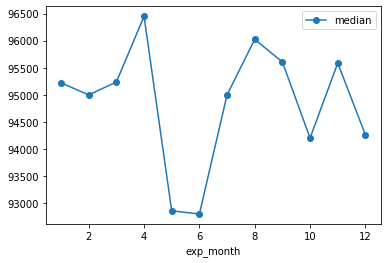

In [69]:
total_area_pivot = data.pivot_table(index='exp_month', values='price_per_square', aggfunc=['count', 'mean', 'median'])
total_area_pivot.columns = ['count', 'mean', 'median']

total_area_pivot.plot(y='median', style='o-')


Самое неблагоприятное время для покупки квартиры - апрель и август. Показатели стоимости ниже всего в мае и июне. Возможно, все зависит от сезона. Интересно было бы посмотреть данные с указанием автора объявления (собственник - агенство/риелтор). Скорее всего, начало лета - время отпусков, поэтому стоимость к этим месяцам стремится к минимальному по медиане показателю. 

<AxesSubplot:xlabel='exp_year'>

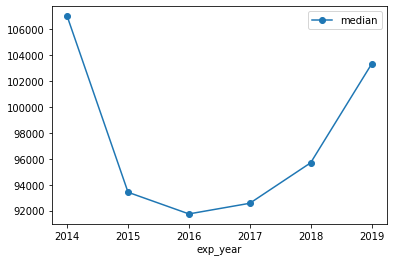

In [70]:
total_area_pivot = data.pivot_table(index='exp_year', values='price_per_square', aggfunc=['count', 'mean', 'median'])
total_area_pivot.columns = ['count', 'mean', 'median']

total_area_pivot.plot(y='median', style='o-')

Начиная с 2014 по 2016 год, цена падала. Затем, к 2019 стала возвращаться в прежние значения. Возможно, это обусловено экономической ситуацией в стране, активностью застройки, нужна информация по вторичности рынка. Возможно, к 2025ому году план застройки постарается удовлетворить спрос на новое жилье. Слишком много факторов неизвестны, поэтому можно только предполагать.

Больше всего на стоимость квартиры влияют общая площадь, высота потолков, кол-во комнат. Указал это в общем выводе до первой проверки. Забыл добавить в качестве промежуточного среза. Но и делать такие выводы до финала проекта - тяжеловато. 

#### Задание 4

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.

In [71]:
locality_pivot = data.pivot_table(index='locality_name', values='price_per_square', aggfunc=['mean', 'count'])
locality_pivot.columns = ['mean', 'count']
locality_pivot = locality_pivot.sort_values('count', ascending=False).head(10)


#Минимальная стоимость жилья
min_price = locality_pivot[locality_pivot['mean'] == locality_pivot['mean'].min()]

#Максимальная стоимость жилья
max_price = locality_pivot[locality_pivot['mean'] == locality_pivot['mean'].max()]

display(max_price)
display(min_price)


,mean,count
locality_name,,
Санкт-Петербург,114848.565231,15721


,mean,count
locality_name,,
Выборг,58141.489451,237


Из городов с самым большим кол-вом объявлений:  
• Самая высокая стоимость квадратного метра в Санкт-Петербурге.  
• Самая низкая в Выборге  

#### Задание 5

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

<AxesSubplot:xlabel='city_center_nearest_km', ylabel='price_km'>

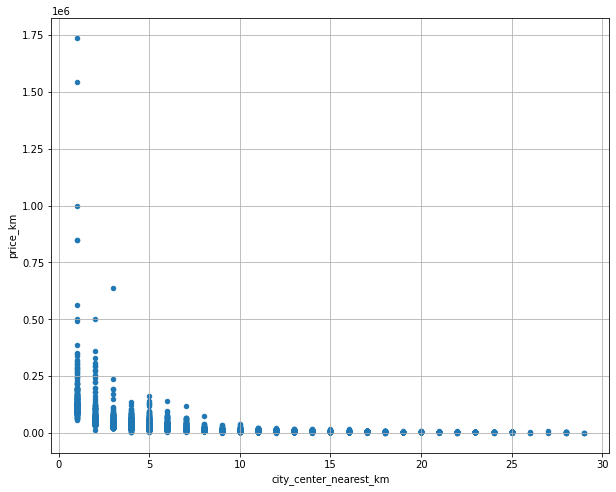

In [72]:
spb = data.loc[data['locality_name'] == 'Санкт-Петербург']
spb = spb.dropna(subset= ['cityCenters_nearest'], inplace=False)

spb['city_center_nearest_km'] = (spb['cityCenters_nearest'] / 1000).astype('int')
spb['km_to_center'].isna().count()

spb['price_km'] =  spb['price_per_square'] / spb['city_center_nearest_km']

spb.plot(x='city_center_nearest_km', y='price_km', kind='scatter', figsize=(10, 8), grid=True)

Цена квадратного метра в Санкт-Петербург, начиная с 5го километра от центра начинает падать. Чем ближе к центру, тем выше стоимость жилья. 

### Общий вывод

Провел работу с данными по продаже квартир. В предобработке нужно было избавиться от пропусков, изменить неверные типы данных. Затем, посчитали и добавили в таблицу цену квадратного метра, из даты получили дни недели, месяцы и годы размещения объявлений о продаже, добавили категории по этажам квартир. Как, наверное, обычно при обучении происходит, в ходе работы появилось больше вопросов, чем ответов. Ощущается недостаток категорий в данных, таких как "автор объявления (собственник - агенство/риелтор)". Эти значения позволили бы точнее строить предположения о появлении выбросов и в распределении данных на графиках. Благодаря графику размаха, удалось выяснить, что квартиры продаются в диапазоне от 1 дня до 2.5 лет. Больше всего на стоимость квартиры влияют общая площадь, высота потолков, кол-во комнат. В Санкт-Петербурге на стоимость квадратного метра, так же, сильно влияет близость к центру города. Центром, по этим данным, условно, можно считать 5 киллометров. В основном квартиры продаются сезонно, это может быть обусловленно большим кол-вом объявлений от агентсв, это так же видно из графика продаж от дня недели, к выходным кол-во объявлений снижается, ко вторнику растет. 

#### Кратко
■ Стоимость квадратного метра зависит от:  
• Размера общей площади  
• Высоты потолков   
• Количества комнат   
■ Стоимость квадратного метра выше всего в Санкт-Петербурге и максимальные значения находятся ближе к центру.


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод